In [8]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
parent_dir = os.path.dirname(parent_dir)
sys.path.append(parent_dir)
print(parent_dir)
import polyscope.imgui as psim
import scipy as sp
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jrandom
import jax.nn as nn
import jax.lax as lax
import jax.random as jrandom
import jax.nn as nn
import jax.lax as lax
import os
import jax.experimental.sparse as jsp
from scipy.sparse import diags, csr_matrix
from src.dataGenerator.spherical_data_generator import *
from src.utils.sht_helper import *
from src.stochastics.sde import *
from src.stochastics.sde_solver import *
import matplotlib.pyplot as plt
import random
def get_random_int():
    return random.randint(0, 1000000)


/home/zjc/PycharmProjects/ShapeSphericalFNO/ShapeSphericalFNO


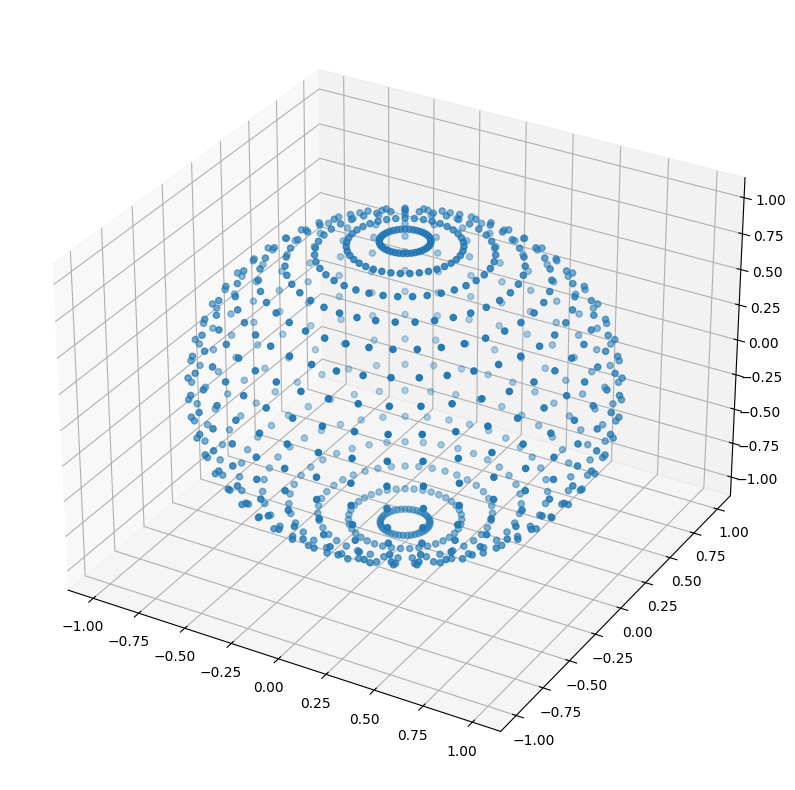

(20, 39, 3)
(60, 40, 3)


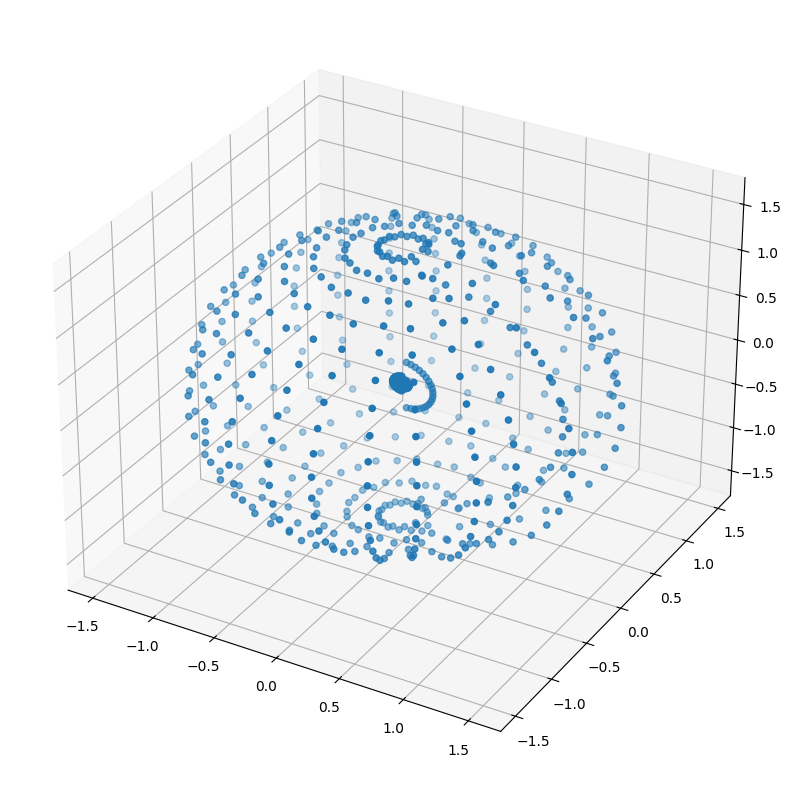

data_sht.shape:  (20, 39, 3)
[[ 5.48976697e-02 -2.04890966e-08  9.98485208e-01]
 [ 5.48703112e-02  1.73302274e-03  9.98485148e-01]
 [ 5.47882542e-02  3.46433278e-03  9.98485267e-01]
 [ 5.46515696e-02  5.19218761e-03  9.98485208e-01]
 [ 5.44604287e-02  6.91487035e-03  9.98485267e-01]
 [ 5.42149879e-02  8.63066502e-03  9.98485327e-01]
 [ 5.39155044e-02  1.03378426e-02  9.98485088e-01]
 [ 5.35622872e-02  1.20347217e-02  9.98485029e-01]
 [ 5.31556644e-02  1.37196137e-02  9.98485148e-01]
 [ 5.26960604e-02  1.53908199e-02  9.98485208e-01]
 [ 5.21839373e-02  1.70466863e-02  9.98485208e-01]
 [ 5.16197905e-02  1.86855644e-02  9.98485208e-01]
 [ 5.10041751e-02  2.03058049e-02  9.98485148e-01]
 [ 5.03377318e-02  2.19058041e-02  9.98484910e-01]
 [ 4.96211126e-02  2.34839749e-02  9.98485088e-01]
 [ 4.88550253e-02  2.50387453e-02  9.98485208e-01]
 [ 4.80402373e-02  2.65685339e-02  9.98485088e-01]
 [ 4.71775569e-02  2.80718636e-02  9.98485148e-01]
 [ 4.62678596e-02  2.95471959e-02  9.98485267e-01]
 [

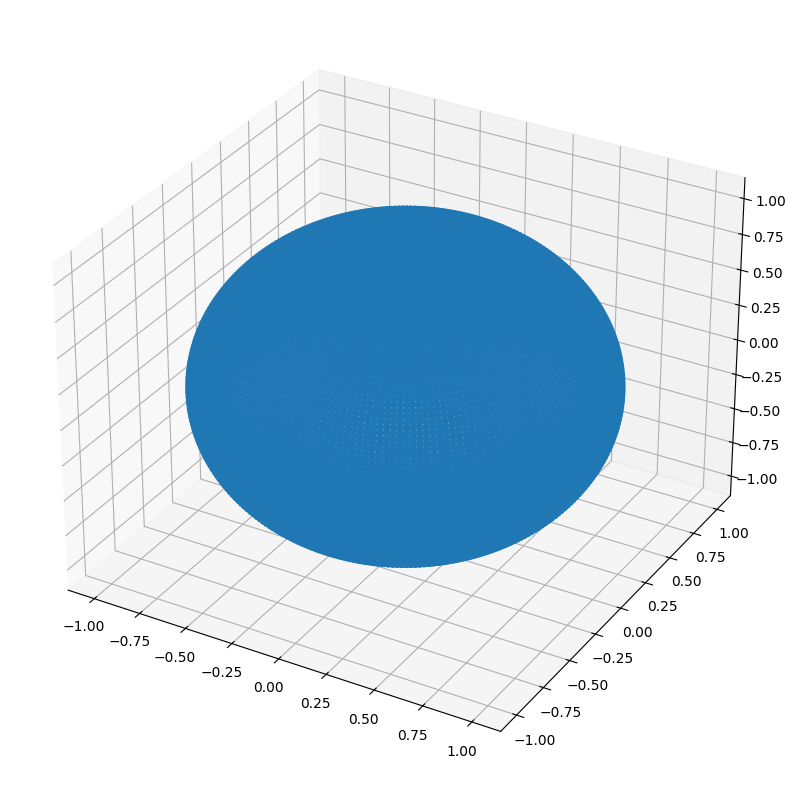

In [9]:
import s2fft
from src.utils.sht_helper import *

L = 20
data_generator = S2ManifoldDataGenerator( sampling="gl", manifold_type="sphere", seed=get_random_int())
data = data_generator.generate_data(L, 1)
data = data[0]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,:,0], data[:,:,1], data[:,:,2])
plt.show()

print(data.shape)
# data_sht = jax.vmap(s2fft.forward, in_axes=(2, None))(data, data_generator.L, sampling=data_generator.sampling, method="jax")
# data_sht = []
# for i in range(data.shape[2]):
#     data_sht.append(s2fft.forward(data[:,:,i], data_generator.L, sampling=data_generator.sampling, method="jax"))
# data_sht = jnp.stack(data_sht, axis=-1)
# L = 15
# x = np.array(data)
data_rfft = jax.vmap(lambda x: jnp.fft.rfft2(x, ( 3*L,3*L), axes=(0,1)), in_axes=(2))(data)
data_rfft = jnp.transpose(data_rfft, (1, 2, 0))
data_rfft_inv = jax.vmap(lambda x: jnp.fft.irfft2(x, ( 3*L,2*L), axes=(0,1)), in_axes=(2))(data_rfft)
data_rfft_inv = jnp.transpose(data_rfft_inv, (1, 2, 0))
print(data_rfft_inv.shape)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_rfft_inv[:,:,0], data_rfft_inv[:,:,1], data_rfft_inv[:,:,2])
plt.show()

data_sht = jax.vmap(lambda x: s2fft.forward(x, L = L, reality=True, sampling=data_generator.sampling, method="jax"), in_axes=(2))(data)
# data = data.transpose(2, 0, 1)
# data_sht = s2fft.forward(data, L = L, reality=True, sampling=data_generator.sampling, method="jax", spin=1)
data_sht = jnp.transpose(data_sht, (1, 2, 0))
print("data_sht.shape: ", data_sht.shape)

data_sht = resize_flm(data_sht, 5 * L)
inv_data_sht = jax.vmap(lambda x: s2fft.inverse(x, L = 5 * L, reality=True, sampling=data_generator.sampling, method="jax"), in_axes=(2))(data_sht)
inv_data_sht = jnp.transpose(inv_data_sht, (1, 2, 0))
print(inv_data_sht[1,:,:])
inv_data_real = jnp.real(inv_data_sht)
print(inv_data_real.shape)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inv_data_real[:,:,0], inv_data_real[:,:,1], inv_data_real[:,:,2])
plt.show()